In [1]:
import time
t1 = time.time()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from typing import Union, Optional
from typing_extensions import TypedDict
from matplotlib.offsetbox import (TextArea, AnnotationBbox)

from lightgbm import LGBMRegressor
from matplotlib.ticker import FormatStrFormatter
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from mapie.metrics import regression_coverage_score, regression_mean_width_score
from sklearn.datasets import fetch_california_housing

from mapie.regression import MapieRegressor
from mapie.quantile_regression import MapieQuantileRegressor
from mapie.subsample import Subsample
from scipy.stats import randint, uniform

round_to = 3
random_state = 23
rng = np.random.default_rng(random_state)

import warnings
warnings.filterwarnings("ignore")


In [3]:
def sort(y_test, y_pred, y_pis):
    indices = np.argsort(y_test)
    y_test_sorted = np.array(y_test)[indices]
    y_pred_sorted = y_pred[indices]
    y_lower_bound = y_pis[:, 0, 0][indices]
    y_upper_bound = y_pis[:, 1, 0][indices]
    return y_test_sorted, y_pred_sorted, y_lower_bound, y_upper_bound


def plot(title, axs, y_test_sorted, y_pred_sorted, lower_bound, upper_bound, coverage, width, num_plots_idx):
    axs.yaxis.set_major_formatter(FormatStrFormatter('%.0f'+"k"))
    axs.xaxis.set_major_formatter(FormatStrFormatter('%.0f'+"k"))

    lower_bound_ = np.take(lower_bound, num_plots_idx)
    y_pred_sorted_ = np.take(y_pred_sorted, num_plots_idx)
    y_test_sorted_ = np.take(y_test_sorted, num_plots_idx)

    error = y_pred_sorted_-lower_bound_

    warning1 = y_test_sorted_ > y_pred_sorted_+error
    warning2 = y_test_sorted_ < y_pred_sorted_-error
    warnings = warning1 + warning2
    axs.errorbar(y_test_sorted_[~warnings], y_pred_sorted_[~warnings], yerr=error[~warnings], capsize=5, marker="o", elinewidth=2, linewidth=0)
    axs.errorbar(y_test_sorted_[warnings], y_pred_sorted_[warnings], yerr=error[warnings], capsize=5, marker="o", elinewidth=2, linewidth=0, color="red")
    axs.scatter(y_test_sorted_[warnings], y_test_sorted_[warnings], marker="*", color="green")
    
    axs.set_xlabel("Prix des maisons en $")
    axs.set_ylabel("Prédiction de prix des maisons en $")
    # axs.annotate(f"Coverage: {coverage}\nWith: {width}", xy=(0.5, np.max(y_pred_sorted_+error)*0.9), fontsize=10)
    ab = AnnotationBbox(
        TextArea(f"Couverture: {coverage}\nLongeur d'intervalles: {width}"), 
        xy=(np.min(y_test_sorted_)*3, np.max(y_pred_sorted_+error)*0.95),
        )
    axs.add_artist(ab)
    axs.set_title(title, fontweight='bold')

# Data

In [4]:
data = fetch_california_housing(as_frame=True)
X = pd.DataFrame(data=data.data, columns=data.feature_names)
y = pd.DataFrame(data=data.target)*100

<AxesSubplot:>

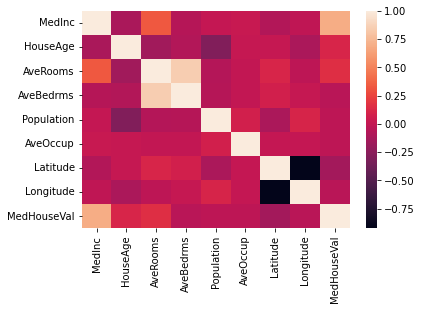

In [29]:
df = pd.concat([X, y], axis=1)
corr = df[df.columns].corr()
sns.heatmap(
        corr,
        xticklabels=corr.columns,
        yticklabels=corr.columns
        )

In [36]:
pear_corr=df.corr(method='pearson')
pear_corr.style.background_gradient(cmap='Greens', axis=0)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.688075
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,0.105623
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.151948
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.046701
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,-0.024650
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476,-0.023737
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664,-0.144160
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000,-0.045967
MedHouseVal,0.688075,0.105623,0.151948,-0.046701,-0.024650,-0.023737,-0.144160,-0.045967,1.000000


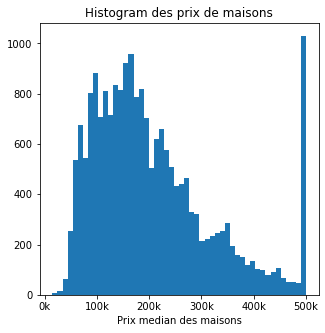

In [6]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.hist(y, bins=50)
axs.set_xlabel("Prix median des maisons")
axs.set_title("Histogram des prix de maisons")
axs.xaxis.set_major_formatter(FormatStrFormatter('%.0f'+"k"))

In [7]:
X[X.select_dtypes(include=["object"]).columns] = X[X.select_dtypes(include=["object"]).columns].astype("category")
X_train, X_test, y_train, y_test = train_test_split(X, y['MedHouseVal'], random_state=random_state)
X_train, X_calib, y_train, y_calib = train_test_split(X_train, y_train, random_state=random_state)

# Optimizing

Optimization of the `LGBMRegressor` using `RandomizedSearchCV` to find the optimal model to predict the house prices.

In [8]:
estimator = LGBMRegressor(objective='quantile', alpha=0.5, random_state=random_state)
params_distributions = dict(
    num_leaves = randint(low=10, high=50),
    max_depth = randint(low=3, high=20),
    n_estimators = randint(low=50, high=300),
    learning_rate = uniform()
)
optim_model = RandomizedSearchCV(
    estimator,
    param_distributions=params_distributions,
    n_jobs=-1,
    n_iter=100,
    cv=KFold(n_splits=5),
    verbose=-1
)
optim_model.fit(X_train, y_train)
estimator = estimator.set_params(**optim_model.best_params_)

# Comparaison

Compairing the differents regression methods available in MAPIE.

In [9]:
Params = TypedDict("Params", {"method": str, "cv": Union[int, str], "alpha": Optional[float]})
STRATEGIES = {
    "naive": Params(method="naive"),
    "jackknife_plus_ab": Params(method="plus", cv=Subsample(n_resamplings=50)),
    "cv_plus": Params(method="plus", cv=10),
    "cqr": Params(method="quantile", cv="split", alpha=0.2)
}
y_pred, y_pis = {}, {}
y_test_sorted, y_pred_sorted, lower_bound, upper_bound = {}, {}, {}, {}
coverage, width = {}, {}
for strategy, params in STRATEGIES.items():
    if strategy == "cqr":
        mapie = MapieQuantileRegressor(estimator, **params)
        mapie.fit(X_train, y_train, X_calib=X_calib, y_calib=y_calib)
        y_pred[strategy], y_pis[strategy] = mapie.predict(X_test)
    else:
        mapie = MapieRegressor(estimator, **params)
        mapie.fit(X_train, y_train)
        y_pred[strategy], y_pis[strategy] = mapie.predict(X_test, alpha=0.2)
    y_test_sorted[strategy], y_pred_sorted[strategy], lower_bound[strategy], upper_bound[strategy] = sort(y_test, y_pred[strategy], y_pis[strategy])
    coverage[strategy] = np.round(regression_coverage_score(y_test, y_pis[strategy][:, 0, 0], y_pis[strategy][:, 1, 0]), round_to)
    width[strategy] = np.round(regression_mean_width_score(y_pis[strategy][:, 0, 0], y_pis[strategy][:, 1, 0]), round_to)


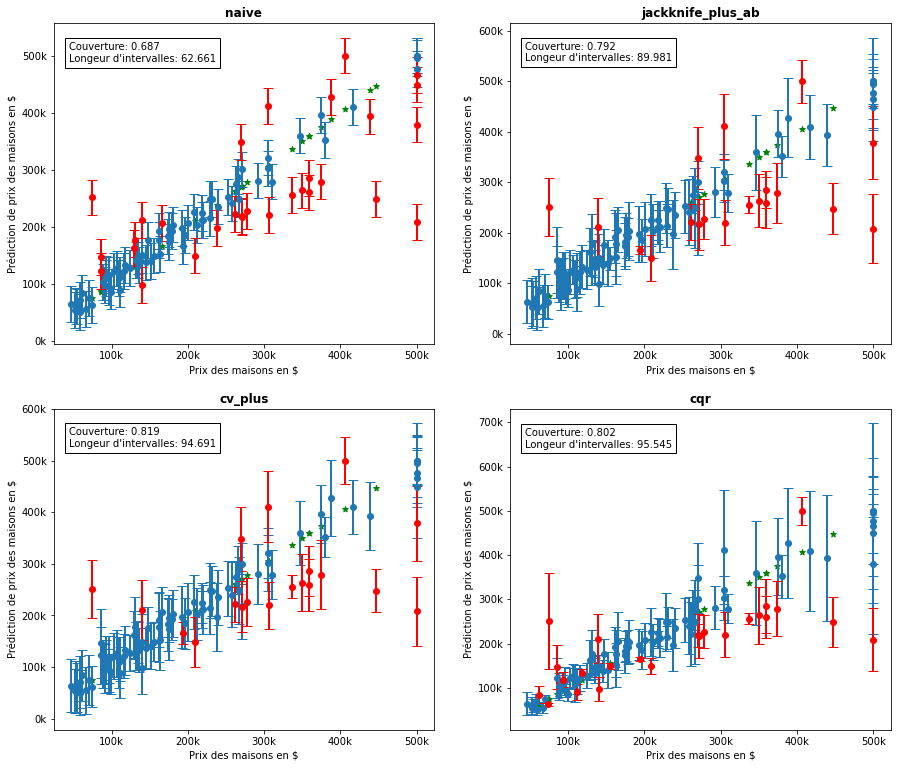

In [18]:
perc_obs_plot = 0.02
num_plots = rng.choice(len(y_test), int(perc_obs_plot*len(y_test)), replace=False)
fig, axs = plt.subplots(2, 2, figsize=(15, 13))
coords = [axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]]
for strategy, coord in zip(STRATEGIES.keys(), coords):
    plot(strategy, coord, y_test_sorted[strategy], y_pred_sorted[strategy], lower_bound[strategy], upper_bound[strategy], coverage[strategy], width[strategy], num_plots)

We notice more adaptability of the prediction intervals for the conformalized quantile regression while the other methods have fixed interval width.

In [19]:
def get_bins(want, y_test, y_pred, lower_bound, upper_bound, STRATEGIES, bins):
    """
    Splits the data into different sections according to the bins selected. 
    Computes the coverage and width of that split.
    """
    cuts = []
    cuts_ = pd.qcut(y_test["naive"], bins).unique()[:-1]
    for item in cuts_:
        cuts.append(item.left)
    cuts.append(cuts_[-1].right)
    cuts.append(np.max(y_test["naive"])+1)
    recap ={}
    for i in range(len(cuts)-1):
        cut1, cut2 = cuts[i], cuts[i+1]
        name = f"[{np.round(cut1, 0)}, {np.round(cut2, 0)}]"
        recap[name] = []
        for strategy in STRATEGIES:
            indices = np.where((y_test[strategy]>cut1)*(y_test[strategy]<=cut2))
            y_test_trunc = np.take(y_test[strategy], indices)
            y_low_ = np.take(lower_bound[strategy], indices)
            y_high_ = np.take(upper_bound[strategy], indices)
            if want=="coverage":
                recap[name].append(regression_coverage_score(y_test_trunc[0], y_low_[0], y_high_[0]))
            elif want=="width":
                recap[name].append(regression_mean_width_score(y_low_[0], y_high_[0]))
    recap_df = pd.DataFrame(recap, index=STRATEGIES)
    return recap_df

In [20]:
bins = list(np.arange(0, 1, 0.1))
binned_data = get_bins("coverage", y_test_sorted, y_pred_sorted, lower_bound, upper_bound, STRATEGIES, bins)

To confirm this insights, we will now observe what happens when we plot the conditional coverage and interval width on these intervals.

<Figure size 432x288 with 0 Axes>

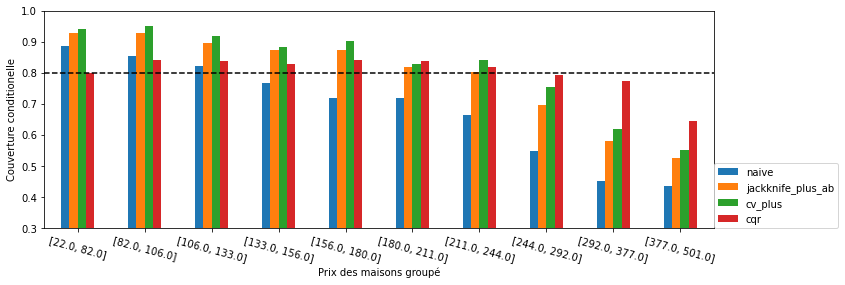

In [21]:
fig = plt.figure()
binned_data.T.plot.bar(figsize=(12, 4))
plt.axhline(0.80, ls="--", color="k")
plt.ylabel("Couverture conditionelle")
plt.xlabel("Prix des maisons groupé")
plt.xticks(rotation=345)
plt.ylim(0.3, 1.0)
plt.legend(loc=[1, 0])

What we observe from these results is that none of the methods seems to have conditional coverage. It is however suprising to see that the conformalized quantile regression does not outperform the other methods.

In [22]:
binned_data = get_bins("width", y_test_sorted, y_pred_sorted, lower_bound, upper_bound, STRATEGIES, bins)

<Figure size 432x288 with 0 Axes>

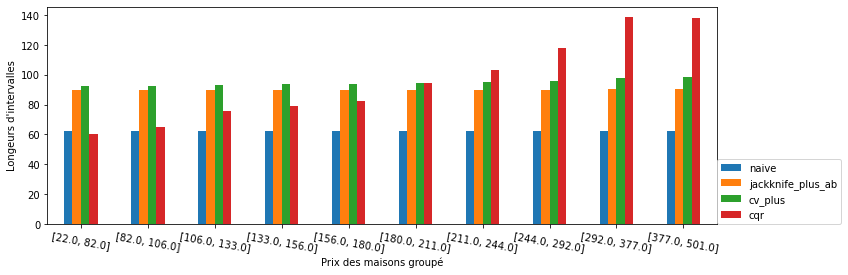

In [23]:
fig = plt.figure()
binned_data.T.plot.bar(figsize=(12, 4))
plt.ylabel("Longeurs d'intervalles")
plt.xlabel("Prix des maisons groupé")
plt.xticks(rotation=350)
plt.legend(loc=[1, 0])

When observing the values of the the interval width we again see what was observed in the previous graphs with the interval widths. We can again see that the prediction intervals are larger as the price of the houses increases, interestingly, it's important to note that the prediction intervals are shorter when the estimator is more certain.

In [16]:
t2 = time.time()

In [17]:
print(t2 - t1)

112.3482620716095
